In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, gc
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [3]:
DATA_DIR = '/home/chicm/data/planet'
RESULT_DIR = DATA_DIR+'/results'

df_train = pd.read_csv(DATA_DIR+'/train.csv')

print(df_train.values[:5])

[['train_0' 'haze primary']
 ['train_1' 'agriculture clear primary water']
 ['train_2' 'clear primary']
 ['train_3' 'clear primary']
 ['train_4' 'agriculture clear habitation primary road']]


In [4]:
labels = ['haze', 'cultivation', 'blooming', 'partly_cloudy', 'habitation', 'primary',
            'road', 'agriculture', 'selective_logging', 'artisinal_mine', 'slash_burn',
            'blow_down', 'cloudy', 'bare_ground', 'conventional_mine', 'clear', 'water']

cloudy_index = 12 


In [5]:
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [6]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [14]:
x_train = []
y_train = []
for f, tags in tqdm(df_train.values, miniters=5000):
    fn = DATA_DIR+'/train-jpg/'+f+'.jpg'
    img = cv2.imread(fn) 
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(cv2.resize(img, (128,128)))
    y_train.append(targets)

100%|██████████| 40479/40479 [00:37<00:00, 1068.59it/s]


In [18]:
x_train = np.array(x_train, np.float32) / 255.

In [27]:
y_train = np.array(y_train, np.uint8)

## predict train data

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D

def get_conv_layers(input_shape):
    return [    
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(axis=1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.15),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(axis=1),
        #MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.15),
        #Flatten(),
        #Dense(128, activation='relu'),
        #BatchNormalization(),
        #Dropout(0.5),
        #Dense(128, activation='relu'),
        #BatchNormalization(),
        #Dropout(0.5),
        #Dense(17, activation='sigmoid')
        Conv2D(17, (3,3), activation='relu'),
        BatchNormalization(axis=1),
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ]

def get_conv_model(input_shape):
    model = Sequential(get_conv_layers(input_shape))
    model.compile(Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
import glob
TRAIN_PRED_FILE = RESULT_DIR + '/train_preds'

def ensemble():
    preds = []
    w_files = glob.glob(RESULT_DIR+'/kfw*.h5')
    for fn in w_files:
        model = get_conv_model(x_train.shape[1:])
        print(fn)
        model.load_weights(fn)
        preds.append(model.predict(x_train, batch_size=128))
    m = np.mean(preds, axis=0)
    print(m.shape)
    save_array(TRAIN_PRED_FILE, m)

In [21]:
ensemble()

/home/chicm/data/planet/results/kfw_3.h5
/home/chicm/data/planet/results/kfw_1.h5
/home/chicm/data/planet/results/kfw_2.h5
/home/chicm/data/planet/results/kfw_4.h5
(40479, 17)


In [25]:
train_preds = load_array(TRAIN_PRED_FILE)

In [26]:
print(train_preds[:3])

[[ 0.53954929  0.02649718  0.00276628  0.03186901  0.00640998  0.99528968
   0.02603975  0.04283186  0.00176348  0.00166013  0.00171969  0.00157475
   0.00551392  0.00278954  0.0016178   0.56565088  0.03867776]
 [ 0.00336078  0.13225007  0.00222772  0.01343094  0.12314206  0.99941528
   0.75278652  0.68333745  0.00699641  0.00373324  0.00329265  0.00233218
   0.00164881  0.00646424  0.00164165  0.98146999  0.97215998]
 [ 0.00245685  0.02883123  0.00462019  0.01083991  0.00483936  0.99650127
   0.01547493  0.03525309  0.00309774  0.0015793   0.00214163  0.00263154
   0.00154017  0.00341816  0.00149945  0.96949291  0.02079906]]


In [28]:
print(y_train[:3])

[[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]]


## find best threshold for F2 score

In [34]:
def gen_sub(preds, threshold):
    sub = preds.copy()
    for i, row in enumerate(preds):
        for j, e in enumerate(row):
            if e >= threshold:
                sub[i][j] = 1
            else:
                sub[i][j] = 0
    return sub

In [35]:
sub1 = gen_sub(train_preds, 0.18)

In [36]:
print(sub1[:3])

[[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


In [37]:
from sklearn.metrics import fbeta_score
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='samples')


In [38]:
score = f2_score(y_train, sub1)
print(score)

0.916114713633


In [43]:
thresh = 0.16
max = 0
while thresh < 0.25:
    sub = gen_sub(train_preds, thresh)
    score = f2_score(y_train, sub)
    if score > max:
        th, max = thresh, score
    thresh += 0.001


0.18800000000000003=>0.9137527776034694


In [44]:
print('{}=>{}'.format(th, max))

0.18800000000000003=>0.9161928787112799


## find incorrect predicted data

In [45]:
sub = gen_sub(train_preds, 0.188)


In [46]:
sub = np.array(sub, np.uint8)

In [50]:
print(sub[:3])
print(y_train[:3])

[[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]]
[[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]]


In [86]:
from sklearn.metrics import accuracy_score
indexes = []

count = 0
for i, row in enumerate(sub):
    if not np.array_equal(row, y_train[i]):
        if accuracy_score(row, y_train[i]) < 0.78:
            indexes.append(i)
            count += 1
print(count)    

946


In [81]:
def get_tags(a, index):
    strtags = ''
    tags = a[index]
    for i, tag in enumerate(tags):
        if tag > 0.18:
            strtags = strtags+','+inv_label_map[i]+'('+str(tag)+')'
    return strtags

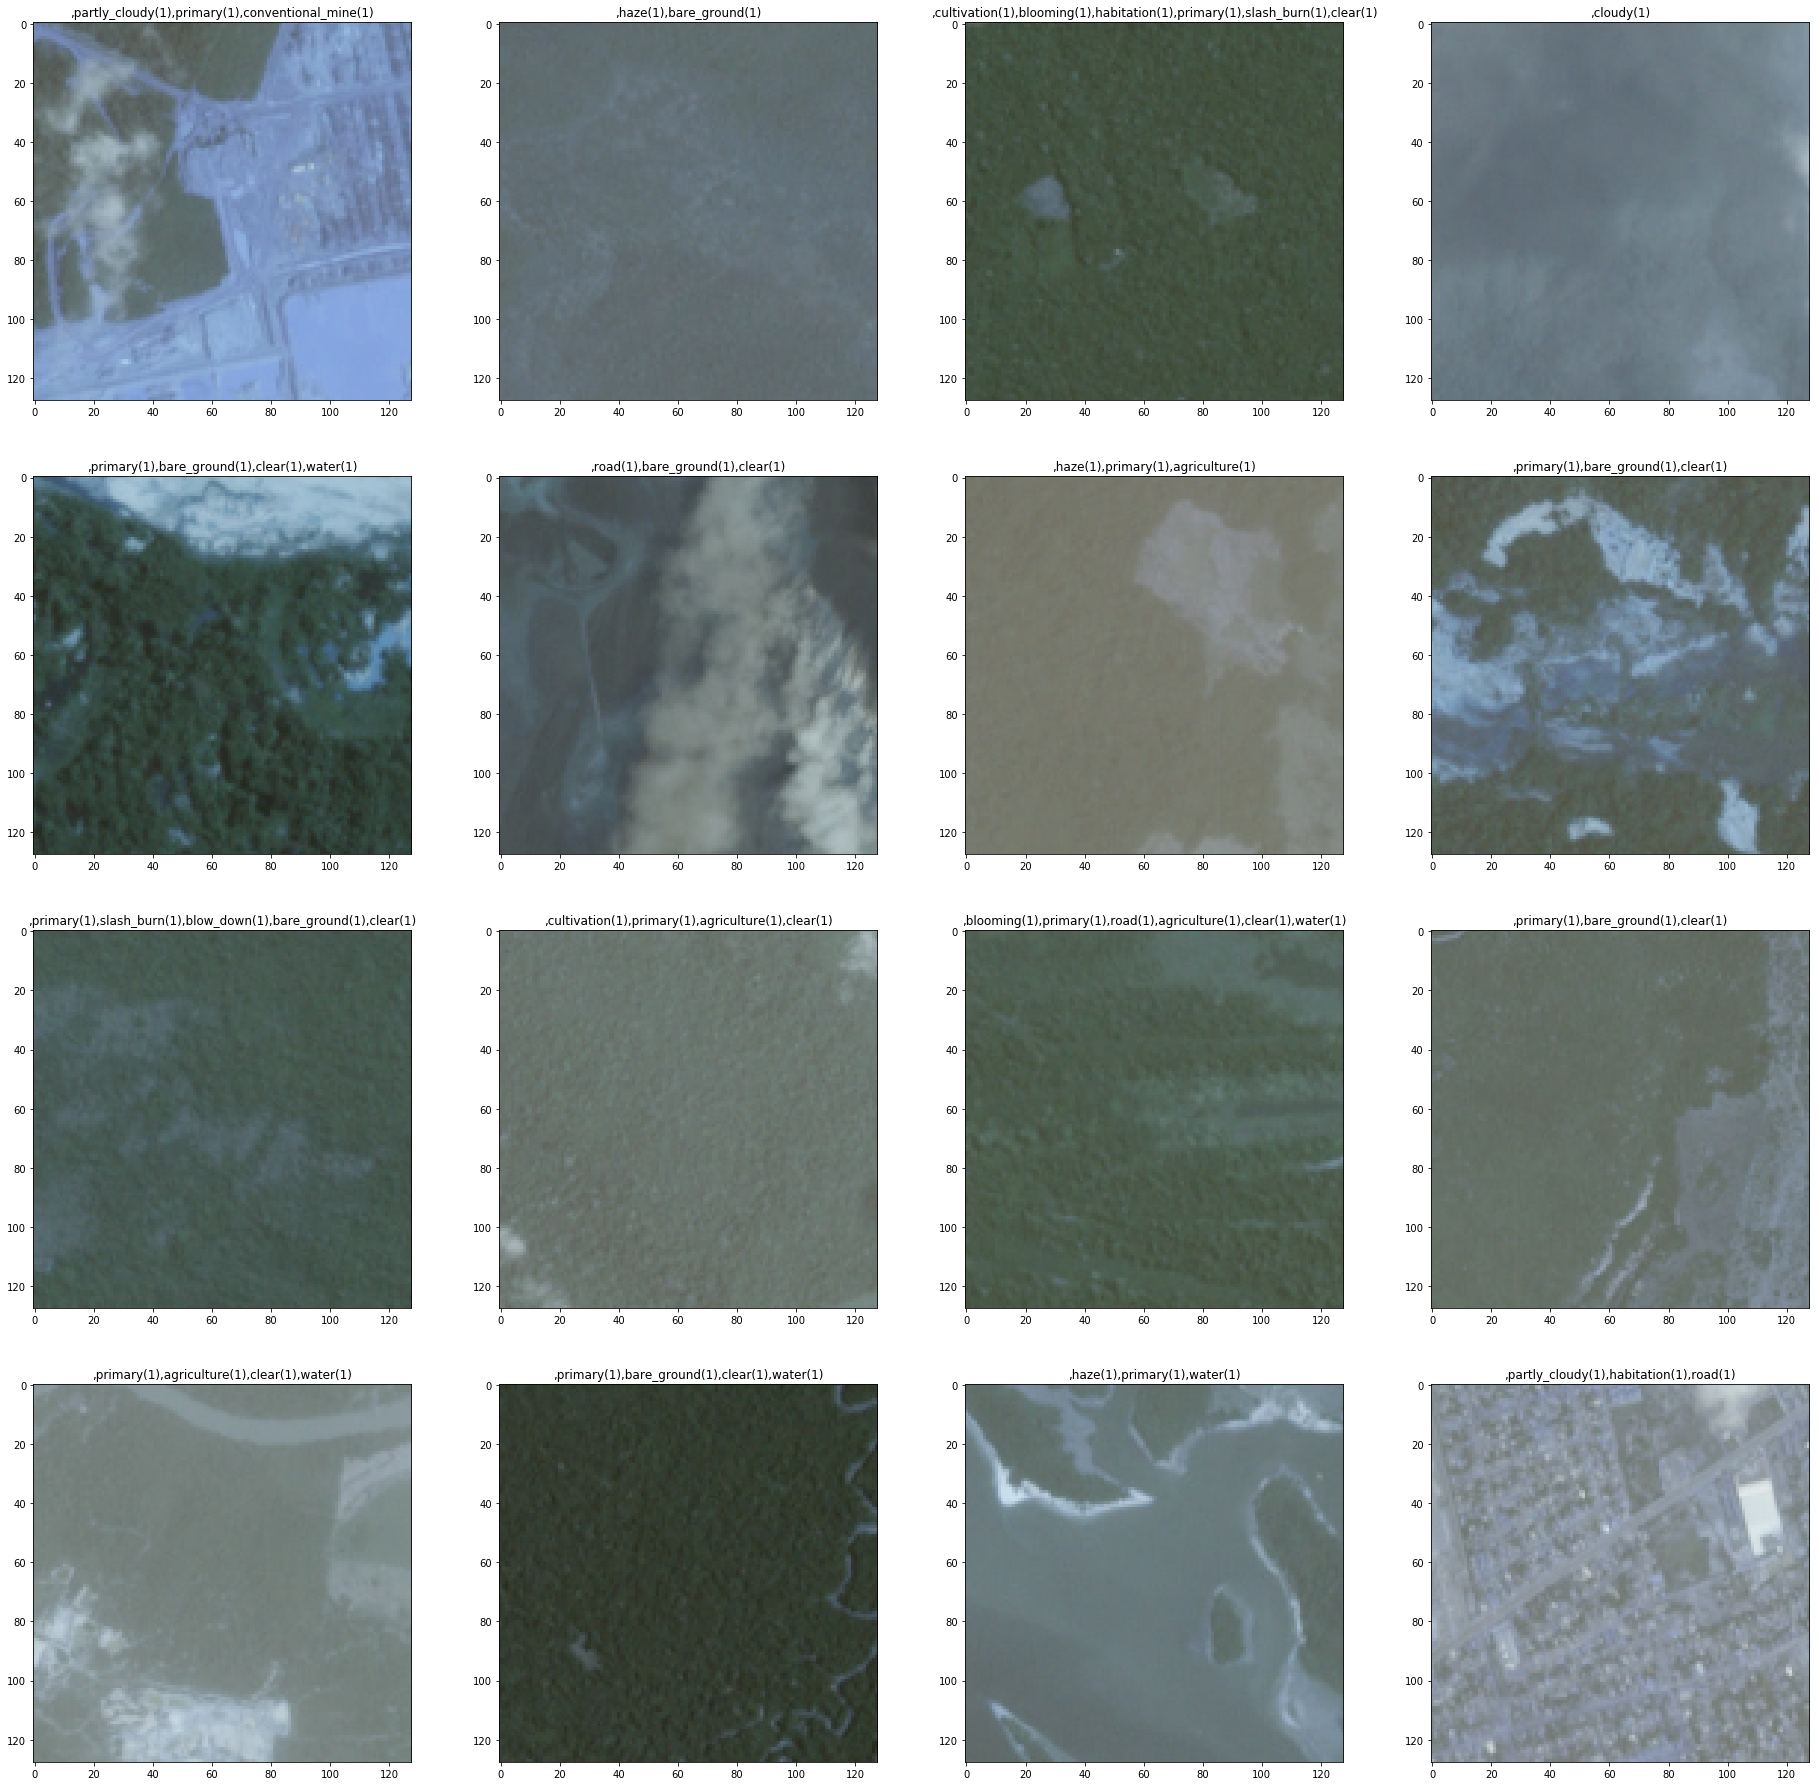

In [87]:
plt.figure(figsize=(32,32))
for i in range(16):
    plt.subplot(4,4,i+1)
    img_ix = indexes[i]
    plt.imshow(x_train[img_ix])
    plt.title(get_tags(y_train, img_ix))

In [88]:
for i in range(16):
    img_ix = indexes[i]
    print(get_tags(train_preds, img_ix))
    print('')

,partly_cloudy(0.376),primary(0.83069),road(0.628647),agriculture(0.472096),bare_ground(0.326788),conventional_mine(0.840994),clear(0.424876),water(0.189484)

,haze(0.226074),primary(0.750613),road(0.2713),agriculture(0.805123),bare_ground(0.226094),clear(0.706241)

,cultivation(0.835027),primary(0.99609),agriculture(0.240314),clear(0.978088)

,haze(0.196582),primary(0.54045),agriculture(0.380417),cloudy(0.310682),clear(0.471191),water(0.403275)

,cultivation(0.211537),habitation(0.280756),primary(0.9931),road(0.453258),agriculture(0.375937),artisinal_mine(0.270096),bare_ground(0.207461),clear(0.970083),water(0.854589)

,partly_cloudy(0.895767),primary(0.289737),agriculture(0.201246),water(0.249547)

,haze(0.732508),cultivation(0.285248),primary(0.996328),road(0.271941),agriculture(0.839761),clear(0.330252),water(0.21071)

,habitation(0.348085),primary(0.975342),road(0.436469),agriculture(0.48741),artisinal_mine(0.27286),bare_ground(0.387245),conventional_mine(0.245189),clear(0.881377)

In [84]:
print(df_train)

        image_name                                               tags
0          train_0                                       haze primary
1          train_1                    agriculture clear primary water
2          train_2                                      clear primary
3          train_3                                      clear primary
4          train_4          agriculture clear habitation primary road
5          train_5                                 haze primary water
6          train_6        agriculture clear cultivation primary water
7          train_7                                       haze primary
8          train_8              agriculture clear cultivation primary
9          train_9         agriculture clear cultivation primary road
10        train_10         agriculture clear primary slash_burn water
11        train_11                                clear primary water
12        train_12                                             cloudy
13        train_13  

In [85]:
print(indexes[:5])

[24, 226, 239, 319, 451]


In [89]:
len(indexes)

946

In [92]:
newdf = df_train.drop(df_train.index[indexes])

In [93]:
newdf

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [95]:
newdf.to_csv(DATA_DIR+'/train_clean.csv', index=False)